# Thiết lập chung

In [1]:
DATA_ROOT = "/kaggle/input/3d-mri-scans-for-alzheimer-disease"
WORK_DIR  = "/kaggle/working"
model_path = f"{WORK_DIR}/baselineB_best_model.pth"

# Thông tin xử lý dữ liệu
number_of_slices = 16
start_, end_ = 0.15, 0.85 # Bỏ phần đầu, phần cuối, lấy phần giữa

# Thông tin mô hình
number_of_child_processes = 0
number_of_epochs = 20
learning_rate = 2e-4
batch_size = 4
threshold_alpha = 0.36 # ngưỡng chia AD và non-AD

# Thông tin bệnh nhân mới
patientId = "073_S_0386" # AD
numer_of_top_slices = 5 # top-k slices

# Thư viện

In [2]:
!pip install -q torch torchvision nibabel scikit-image scikit-learn pandas matplotlib safetensors datasets

In [45]:
# ===== Python core =====
import os
import glob

# ===== Numeric / Data =====
import numpy as np
import pandas as pd

# ===== Visualization =====
import matplotlib.pyplot as plt

# ===== PyTorch =====
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ===== Torch vision=====
import torchvision
from torchvision.models import resnet18, ResNet18_Weights

# ===== Metrics =====
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_curve, auc)

# ===== Medical Imaging =====
import nibabel as nib        # đọc file MRI .nii / .nii.gz

# ===== Khác =====
import pandas as pd
import numpy as np
from PIL import Image
from collections import Counter
import safetensors


# Chuẩn bị dữ liệu

In [4]:
DATA_ROOT = "/kaggle/input/3d-mri-scans-for-alzheimer-disease"
AD_DIR = f"{DATA_ROOT}/abb/ADNI"
CN_DIR = f"{DATA_ROOT}/ecc/ADNI"
model_path = f"{WORK_DIR}/baselineB_best_model.pth"

In [5]:
# Đọc file CSV chứa label
abb_df = pd.read_csv(f"{DATA_ROOT}/abb_9_13_2025.csv")
ecc_df = pd.read_csv(f"{DATA_ROOT}/ecc_9_20_2025.csv")

print("abb shape:", abb_df.shape)
print("ecc shape:", ecc_df.shape)

# Kiểm tra cột
print("abb columns:", abb_df.columns.tolist())
print("ecc columns:", ecc_df.columns.tolist())

abb shape: (7652, 12)
ecc shape: (14293, 12)
abb columns: ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit', 'Modality', 'Description', 'Type', 'Acq Date', 'Format', 'Downloaded']
ecc columns: ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit', 'Modality', 'Description', 'Type', 'Acq Date', 'Format', 'Downloaded']


In [6]:
# Tạo mapping từ Image Data ID sang nhãn
def create_label_mapping(df, label):
    # tìm cột có tên giống "Image Data ID" 
    cols = [c for c in df.columns if c.strip().lower() == "image data id"]
    if len(cols) == 0:
        raise ValueError("CSV không có cột 'Image Data ID' (hoặc bị đổi tên).")
    col = cols[0]

    mapping = {}
    for v in df[col].astype(str).tolist():
        img_id = v.strip()
        if img_id and img_id.lower() != "nan":
            mapping[img_id] = label
    return mapping


# Tạo mapping
ad_mapping = create_label_mapping(abb_df, 'AD')
cn_mapping = create_label_mapping(ecc_df, 'CN')

print(f"Tổng số AD: {len(ad_mapping)}")
print(f"Tổng số CN: {len(cn_mapping)}")

Tổng số AD: 7652
Tổng số CN: 14293


In [7]:
# Tìm file .nii đầu tiên trong thư mục abb và ecc
def find_nii_files(root_dir):
    """Tìm tất cả file .nii trong thư mục"""
    pattern = os.path.join(root_dir, "**", "*.nii")
    nii_files = glob.glob(pattern, recursive=True)

    patient_files = {}
    for fp in sorted(nii_files):  # sort để ổn định
        parts = fp.split("/")
        try:
            adni_idx = parts.index("ADNI")
            patient_id = parts[adni_idx + 1]
        except (ValueError, IndexError):
            continue

        if patient_id not in patient_files:
            patient_files[patient_id] = fp

    return list(patient_files.values())
    
# Tìm file trong abb và ecc
abb_files = find_nii_files(AD_DIR)
ecc_files = find_nii_files(CN_DIR)

print(f"Số file AD (abb): {len(abb_files)}")
print(f"Số file CN (ecc): {len(ecc_files)}")

Số file AD (abb): 166
Số file CN (ecc): 208


In [8]:
# Tạo danh sách tất cả file với nhãn
all_files = []
all_labels = []

def extract_image_id_from_path(file_path):
    filename = os.path.basename(file_path)
    tokens = filename.replace(".", "_").split("_")
    for t in tokens:
        if t.startswith("I") and t[1:].isdigit():
            return t
    return None

# Xử lý file AD
for file_path in abb_files[:200]:  # Giới hạn số lượng nếu cần
    img_id = extract_image_id_from_path(file_path)
    if img_id and img_id in ad_mapping:
        all_files.append(file_path)
        all_labels.append(1)  # AD = 1

# Xử lý file CN
for file_path in ecc_files[:200]:  # Giới hạn số lượng nếu cần
    img_id = extract_image_id_from_path(file_path)
    if img_id and img_id in cn_mapping:
        all_files.append(file_path)
        all_labels.append(0)  # CN = 0

print(f"Tổng số mẫu: {len(all_files)}")
print(f"Số AD: {sum(all_labels)}")
print(f"Số CN: {len(all_labels) - sum(all_labels)}")

Tổng số mẫu: 366
Số AD: 166
Số CN: 200


In [9]:
# Chia train/val/test theo tỉ lệ 60/20/20
X_train_val, X_test, y_train_val, y_test = train_test_split(
    all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)  # 0.25 * 0.8 = 0.2

print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

Train: 219 samples
Validation: 73 samples
Test: 74 samples


In [10]:
def show_class_dist(name, y):
    cnt = Counter(y)
    total = len(y)
    print(f"{name}: total={total}")
    for k in sorted(cnt.keys()):
        print(f"  class {k}: {cnt[k]} ({cnt[k]/total:.3f})")
    print()

show_class_dist("TRAIN", y_train)
show_class_dist("VAL  ", y_val)
show_class_dist("TEST ", y_test)


TRAIN: total=219
  class 0: 120 (0.548)
  class 1: 99 (0.452)

VAL  : total=73
  class 0: 40 (0.548)
  class 1: 33 (0.452)

TEST : total=74
  class 0: 40 (0.541)
  class 1: 34 (0.459)



In [11]:
# Tải ảnh 3D
def load_volume(nii_path):
    img = nib.load(nii_path)
    img = nib.as_closest_canonical(img)
    vol = img.get_fdata().astype(np.float32)
    if vol.ndim != 3:
        raise ValueError(f"Không phải ảnh 3D: {vol.shape}")
    return vol

# Chia cắt 3 hướng
def slices_3views_raw(vol: np.ndarray):
    """
    Trả về 3 lát cắt của 3 hướng:
    - axial:    vol[:, :, z]
    - coronal:  vol[:, y, :]
    - sagittal: vol[x, :, :]
    """
    X, Y, Z = vol.shape

    axial = [vol[:, :, z] for z in range(Z)]      # Độ dài Z, mỗi [X, Y]
    coronal = [vol[:, y, :] for y in range(Y)]    # Độ dài Y, mỗi [X, Z]
    sagittal = [vol[x, :, :] for x in range(X)]   # Độ dài X, mỗi [Y, Z]

    return axial, coronal, sagittal

# Kiểm tra 2 hàm trên có hoạt động không?
nii_path = abb_files[0]   # hoặc ecc_files[0]
vol = load_volume(nii_path)

axial, coronal, sagittal = slices_3views_raw(vol)

print("volume shape:", vol.shape)
print("axial:   count =", len(axial),   "slice shape =", axial[0].shape)
print("coronal: count =", len(coronal), "slice shape =", coronal[0].shape)
print("sagittal:count =", len(sagittal),"slice shape =", sagittal[0].shape)


volume shape: (166, 256, 256)
axial:   count = 256 slice shape = (166, 256)
coronal: count = 256 slice shape = (166, 256)
sagittal:count = 166 slice shape = (256, 256)


# Xử lý dữ liệu

### Lấy mẫu

In [12]:
'''
|---------|====================|---------|
0                  HIPPO                1.0
          ↑          ↑         ↑
         start  hippo_center  end

start = hippo_center - hippo_width_frac / 2
end   = hippo_center + hippo_width_frac / 2
'''

def sample_slices(
    slices,                # DANH SÁCH các lát MRI (ví dụ: 200 lát)
    k=16,                  # Muốn chọn BAO NHIÊU lát?
    start_frac=start_,     # Bỏ 10% ĐẦU (cổ, không quan trọng)
    end_frac=end_,         # Bỏ 10% CUỐI (cằm, không quan trọng)
    hippo_frac=0.6,        # 60% lát ở return sẽ lấy từ vùng Hippocampus (vùng trung tâm)
    hippo_center_frac=0.45,# Hippocampus nằm ở 45% từ trên xuống, tức lấy được lát ở trung tâm
    hippo_width_frac=0.2   # Hippocampus chiếm 20% chiều cao não, tức dùng để xác định khoảng cận [a, b] của vùng trung tâm
):
    """
    ROI-biased slice sampling

    - Ưu tiên hippocampus (axial view)
    - Vẫn giữ slice ngoài ROI để có global context
    - Trả về k slice 2D

    slices: list of 2D slices
    """
    n = len(slices)
    a = int(n * start_frac)
    b = int(n * end_frac)

    if b <= a:
        raise ValueError("Khoảng slice không hợp lệ")

    valid_indices = np.arange(a, b)

    # xác định vùng hippocampus (theo tỉ lệ)
    hippo_center = int(n * hippo_center_frac)
    hippo_half   = int(n * hippo_width_frac / 2)

    hippo_start = max(a, hippo_center - hippo_half)
    hippo_end   = min(b - 1, hippo_center + hippo_half)

    hippo_indices = np.arange(hippo_start, hippo_end + 1)

    # số slice lấy
    k_hippo = int(k * hippo_frac)
    k_other = k - k_hippo

    # sample hippocampus
    if len(hippo_indices) >= k_hippo:
        hippo_sel = np.linspace(
            hippo_indices[0],
            hippo_indices[-1],
            k_hippo
        ).astype(int)
    else:
        hippo_sel = hippo_indices

    # sample ngoài hippocampus
    other_indices = np.setdiff1d(valid_indices, hippo_indices)

    before = other_indices[other_indices < hippo_start]
    after  = other_indices[other_indices > hippo_end]

    k_before = k_other // 2
    k_after  = k_other - k_before

    sel = []

    if len(before) > 0 and k_before > 0:
        sel.extend(
            np.linspace(
                before[0],
                before[-1],
                min(k_before, len(before))
            ).astype(int)
        )

    if len(after) > 0 and k_after > 0:
        sel.extend(
            np.linspace(
                after[0],
                after[-1],
                min(k_after, len(after))
            ).astype(int)
        )

    other_sel = np.array(sel, dtype=int)


    # gộp & sort
    all_idx = np.concatenate([hippo_sel, other_sel])
    all_idx = np.unique(all_idx)

    # nếu thiếu (do trùng), bù đều
    if len(all_idx) < k:
        extra = np.setdiff1d(valid_indices, all_idx)
        if len(extra) > 0:
            extra_sel = np.linspace(
                extra[0],
                extra[-1],
                k - len(all_idx)
            ).astype(int)
            all_idx = np.concatenate([all_idx, extra_sel])

    all_idx = np.sort(all_idx)[:k]

    return [slices[i] for i in all_idx], all_idx


### Chuẩn hóa Z

In [13]:
def normalize_volume_2(vol, eps=1e-6):
    brain_mask = vol > 0
    if not np.any(brain_mask):
        return vol

    brain_values = vol[brain_mask]
    mean = np.mean(brain_values)
    std = np.std(brain_values)

    out = vol.copy()
    out[brain_mask] = (out[brain_mask] - mean) / (std + eps)
    return out

### Đồng bộ kích thước

In [14]:
def pad_to_shape(slice2d: np.ndarray, target_h=256, target_w=256) -> np.ndarray:
    h, w = slice2d.shape

    # CROP nếu quá lớn
    if h > target_h:
        start_h = (h - target_h) // 2
        slice2d = slice2d[start_h:start_h + target_h, :]
        h = target_h

    if w > target_w:
        start_w = (w - target_w) // 2
        slice2d = slice2d[:, start_w:start_w + target_w]
        w = target_w

    # PAD nếu quá nhỏ
    pad_h = target_h - h
    pad_w = target_w - w

    pad_top    = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left   = pad_w // 2
    pad_right  = pad_w - pad_left

    slice_padded = np.pad(
        slice2d,
        ((pad_top, pad_bottom), (pad_left, pad_right)),
        mode="constant",
        constant_values=0
    )

    return slice_padded

def brain_bbox_2d(slice2d, thr=None, margin=10):
    # slice2d: (H,W)
    s = slice2d
    
    nonzero = s[s != 0]
    if nonzero.size == 0:
        return None

    thr = np.percentile(nonzero, 10) 
    if thr < 0: thr = 0               # chặn thr âm để khỏi ăn nền

    mask = s > thr
    if not np.any(mask):
        mask = (s != 0)

    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()

    y0 = max(0, y0 - margin)
    y1 = min(s.shape[0] - 1, y1 + margin)
    x0 = max(0, x0 - margin)
    x1 = min(s.shape[1] - 1, x1 + margin)

    return (y0, y1, x0, x1)


In [15]:
def crop_then_pad(slice2d, target_h=256, target_w=256, view=None):
    bb = brain_bbox_2d(slice2d, margin=12)
    if bb is not None:
        y0, y1, x0, x1 = bb

        if view == "axial":
            w = x1 - x0 + 1
            x1 = x1 - int(0.25 * w)


        elif view == "coronal":
            w = x1 - x0 + 1
            x0 = x0 + int(0.40 * w)

        elif view == "sagittal":
            h = y1 - y0 + 1
            w = x1 - x0 + 1
            x0 = x0 + int(0.28 * h) # cổ
            y1 = y1 - int(0.10 * w) # mặt

        # safety
        if y1 <= y0 or x1 <= x0:
            y0, y1, x0, x1 = bb

        slice2d = slice2d[y0:y1+1, x0:x1+1]


    h, w = slice2d.shape
    if h < target_h or w < target_w:
 
        return pad_to_shape(slice2d, target_h, target_w)

    start_h = (h - target_h) // 2
    start_w = (w - target_w) // 2
    return slice2d[start_h:start_h+target_h, start_w:start_w+target_w]

### Tổng hợp

In [16]:
# Pipeline cho 1 file nii
def process_one_nii(nii_path):
    vol = load_volume(nii_path)

    # Chuẩn hóa
    vol = normalize_volume_2(vol)
    axial, coronal, sagittal = slices_3views_raw(vol)

    # Lấy mẫu
    axial_slices, axial_idx = sample_slices(axial, k=number_of_slices, hippo_frac=0.6)
    coronal_slices, coronal_idx = sample_slices(coronal, k=number_of_slices, hippo_frac=0.3)
    sagittal_slices, sagittal_idx = sample_slices(sagittal, k=number_of_slices, hippo_frac=0.1)


    slices = axial_slices + coronal_slices + sagittal_slices

    indices_slices = (
      [("axial", i) for i in axial_idx] +
      [("coronal", i) for i in coronal_idx] +
      [("sagittal", i) for i in sagittal_idx]
    )

    # crop + pad
    out = []
    for (view_name, _), s in zip(indices_slices, slices):
        s = crop_then_pad(s, view=view_name)   # thêm view_name
        out.append(s)

    return np.array(out), indices_slices  # shape (48,256,256)

x48, idx = process_one_nii(nii_path)
print(x48.shape, type(x48), x48.dtype)
print("min/max:", x48.min(), x48.max())
print("first idx:", idx[0], "last idx:", idx[-1])

(48, 256, 256) <class 'numpy.ndarray'> float32
min/max: -0.7894884 5.6257486
first idx: ('axial', np.int64(38)) last idx: ('sagittal', np.int64(140))


In [17]:
def preprocess_split(X, y, split_name="Train", log_every=30, to_float16=True):
    processed = []
    failed = []

    for i, (file_path, label) in enumerate(zip(X, y), 1):
        try:
            data_slices, slice_index = process_one_nii(file_path)

            if to_float16:
                data_slices = data_slices.astype(np.float16)  # giảm RAM 1/2

            processed.append({
                "file": file_path,
                "slice_index": slice_index,
                "y": int(label),
                "data": data_slices
            })

            if (i % log_every == 0) or (i == 1) or (i == len(X)):
                print(f"[{split_name} {i}/{len(X)}] ok -> {data_slices.shape}, y={label}")

        except Exception as e:
            failed.append((file_path, str(e)))
            print(f"[{split_name} {i}/{len(X)}] FAIL: {os.path.basename(file_path)} | {e}")

    print(f"\n[{split_name}] done: ok={len(processed)}, fail={len(failed)}")
    return processed, failed


processed_train, failed_train = preprocess_split(X_train, y_train, "Train", log_every=30)
processed_val,   failed_val   = preprocess_split(X_val, y_val, "Val", log_every=30)
processed_test,  failed_test  = preprocess_split(X_test, y_test, "Test", log_every=30)

print("\nTiền xử lý hoàn tất:")
print(f"Train: {len(processed_train)} samples")
print(f"Validation: {len(processed_val)} samples")
print(f"Test: {len(processed_test)} samples")


[Train 1/219] ok -> (48, 256, 256), y=0
[Train 30/219] ok -> (48, 256, 256), y=1
[Train 60/219] ok -> (48, 256, 256), y=0
[Train 90/219] ok -> (48, 256, 256), y=0
[Train 120/219] ok -> (48, 256, 256), y=1
[Train 150/219] ok -> (48, 256, 256), y=0
[Train 180/219] ok -> (48, 256, 256), y=1
[Train 210/219] ok -> (48, 256, 256), y=1
[Train 219/219] ok -> (48, 256, 256), y=1

[Train] done: ok=219, fail=0
[Val 1/73] ok -> (48, 256, 256), y=1
[Val 30/73] ok -> (48, 256, 256), y=0
[Val 60/73] ok -> (48, 256, 256), y=0
[Val 73/73] ok -> (48, 256, 256), y=0

[Val] done: ok=73, fail=0
[Test 1/74] ok -> (48, 256, 256), y=0
[Test 30/74] ok -> (48, 256, 256), y=1
[Test 60/74] ok -> (48, 256, 256), y=1
[Test 74/74] ok -> (48, 256, 256), y=0

[Test] done: ok=74, fail=0

Tiền xử lý hoàn tất:
Train: 219 samples
Validation: 73 samples
Test: 74 samples


In [18]:
def count_labels(processed):
    ys = [r["y"] for r in processed]
    c0 = ys.count(0)
    c1 = ys.count(1)
    total = len(ys)
    print(f"total={total} | CN(0)={c0} ({c0/total:.3f}) | AD(1)={c1} ({c1/total:.3f})")

print("\nBalance AFTER preprocessing:")
print("Train:", end=" "); count_labels(processed_train)
print("Val:  ", end=" "); count_labels(processed_val)
print("Test: ", end=" "); count_labels(processed_test)


Balance AFTER preprocessing:
Train: total=219 | CN(0)=120 (0.548) | AD(1)=99 (0.452)
Val:   total=73 | CN(0)=40 (0.548) | AD(1)=33 (0.452)
Test:  total=74 | CN(0)=40 (0.541) | AD(1)=34 (0.459)


In [19]:
# Xem danh sách test 
def get_patient_id_from_path(p):
    # ví dụ path: .../ADNI/005_S_0814/...
    parts = p.split("/")
    if "ADNI" in parts:
        i = parts.index("ADNI")
        if i + 1 < len(parts):
            return parts[i+1]
    return None

def list_test_patients(X_test, y_test):
    patients = {}
    for p, y in zip(X_test, y_test):
        pid = get_patient_id_from_path(p)
        if pid is None:
            continue
        patients[pid] = y   # mỗi patient 1 file

    print(f"=== TEST SET: {len(patients)} PATIENTS ===")
    for pid, y in sorted(patients.items()):
        label = "AD" if y == 1 else "CN"
        print(f"{pid:15s} | GT = {label}")

    return patients

test_patients = list_test_patients(X_test, y_test)

=== TEST SET: 74 PATIENTS ===
002_S_0413      | GT = CN
002_S_0955      | GT = AD
005_S_0814      | GT = AD
006_S_0484      | GT = CN
006_S_0653      | GT = AD
007_S_1206      | GT = CN
007_S_1222      | GT = CN
013_S_0592      | GT = AD
013_S_1276      | GT = CN
020_S_1288      | GT = CN
021_S_0337      | GT = CN
022_S_0007      | GT = AD
022_S_0014      | GT = CN
022_S_0096      | GT = CN
022_S_0129      | GT = AD
023_S_0058      | GT = CN
023_S_0061      | GT = CN
023_S_0083      | GT = AD
023_S_1306      | GT = CN
027_S_1081      | GT = AD
027_S_1082      | GT = AD
029_S_0843      | GT = CN
031_S_0618      | GT = CN
033_S_0724      | GT = AD
033_S_0733      | GT = AD
033_S_0739      | GT = AD
035_S_0156      | GT = CN
035_S_0555      | GT = CN
036_S_1023      | GT = CN
041_S_1002      | GT = CN
041_S_1435      | GT = AD
052_S_1250      | GT = CN
052_S_1251      | GT = CN
057_S_0818      | GT = CN
057_S_0934      | GT = CN
062_S_0730      | GT = AD
067_S_0029      | GT = AD
067_S_02

In [20]:
def get_patient_id_from_path(p):
    parts = p.split("/")
    if "ADNI" in parts:
        i = parts.index("ADNI")
        if i + 1 < len(parts):
            return parts[i+1]
    return None


def show_raw_vs_processed(
    processed_list,
    patient_id,
    view="axial",        # "axial" | "coronal" | "sagittal"
    local_idx=8          # 0..15
):
    # tìm sample theo patient_id
    sample = None
    for r in processed_list:
        pid = get_patient_id_from_path(r["file"])
        if pid == patient_id:
            sample = r
            break

    if sample is None:
        # debug: show vài patient_id có trong list
        example = []
        for r in processed_list[:10]:
            example.append(get_patient_id_from_path(r["file"]))
        print("Không tìm thấy patient_id:", patient_id)
        print("Ví dụ patient_id đang có trong processed_list (10 cái đầu):", example)
        return

    # load volume gốc 
    nii_path = sample["file"]
    vol = load_volume(nii_path)

    # map proc_idx theo view
    if view == "axial":
        proc_idx = local_idx
    elif view == "coronal":
        proc_idx = number_of_slices + local_idx
    elif view == "sagittal":
        proc_idx = 2 * number_of_slices + local_idx
    else:
        raise ValueError("view phải là axial | coronal | sagittal")

    # raw_idx lấy theo slice_index 
    v, raw_idx = sample["slice_index"][proc_idx]
    raw_idx = int(raw_idx)

    if v != view:
        print(f"proc_idx={proc_idx} nhưng slice_index báo view={v}, bạn chọn view={view}. Auto dùng view={v}.")
        view = v

    # cắt raw slice đúng hướng
    if view == "axial":
        raw_slice = vol[:, :, raw_idx]
    elif view == "coronal":
        raw_slice = vol[:, raw_idx, :]
    else:  # sagittal
        raw_slice = vol[raw_idx, :, :]

    proc_slice = sample["data"][proc_idx]

    # plot
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(raw_slice.T, cmap="gray", origin="lower")
    plt.title(f"RAW {view} (idx={raw_idx})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(proc_slice.T, cmap="gray", origin="lower")
    plt.title(f"PREPROCESSED (proc_idx={proc_idx})")
    plt.axis("off")


    y = sample.get("y", None)
    diag = "AD" if y == 1 else "CN" if y == 0 else "?"
    plt.suptitle(f"{patient_id} | y={y} ({diag})", fontsize=14)

    plt.tight_layout()
    plt.show()


In [21]:
patient_to_check = "082_S_0363"

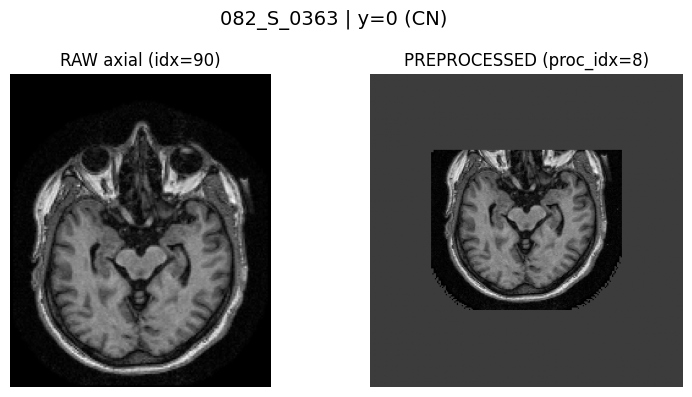

In [22]:
show_raw_vs_processed(
    processed_list=processed_train, # hoặc processed_val / processed_test
    patient_id=patient_to_check,
    view="axial",
    local_idx=8
)

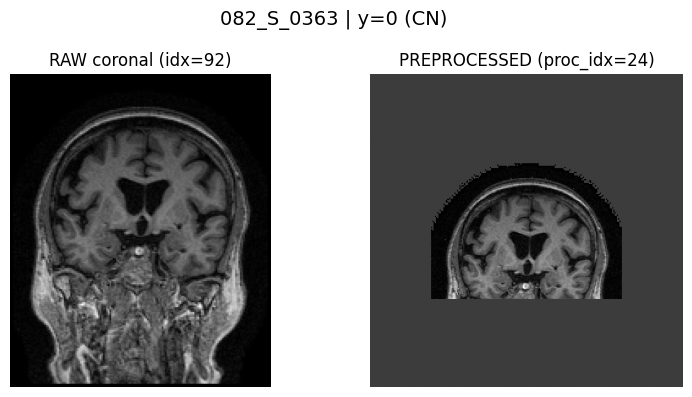

In [23]:
show_raw_vs_processed(
    processed_list=processed_train,
    patient_id=patient_to_check,
    view="coronal",
    local_idx=8
)

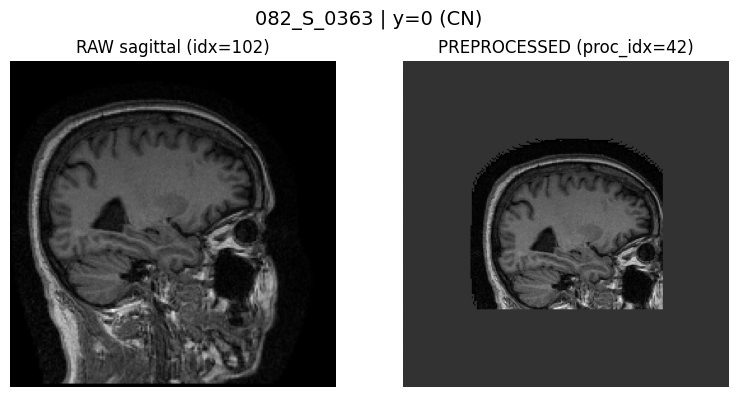

In [24]:
show_raw_vs_processed(
    processed_list=processed_train,
    patient_id=patient_to_check,
    view="sagittal",
    local_idx=10
)

In [25]:
# Kiểm tra số mẫu trùng (phải = 0)
train_files = set(r["file"] for r in processed_train)
val_files   = set(r["file"] for r in processed_val)
print("Overlap train/val:", len(train_files & val_files))

Overlap train/val: 0


# Mô hình hóa

In [26]:
# Xóa tệp mô hình cũ
if os.path.exists(model_path):
    os.remove(model_path)
    print("Đã xóa file:", model_path)
else:
    print("Không tìm thấy file để xóa:", model_path)

Đã xóa file: /kaggle/working/baselineB_best_model.pth


**Ý tưởng mô hình**

Dataset gồm N bệnh nhân, chia thành:
- Train: a bệnh nhân
- Validation: b bệnh nhân
- Test: c bệnh nhân
  
Huấn luyện theo epoch. Trong mỗi epoch, mô hình học toàn bộ bệnh nhân tập train theo batch.

Mỗi bệnh nhân được biểu diễn bằng 48 lát cắt MRI 2D (grayscale).
Input batch có dạng: (B, 48, 1, 256, 256).

Tất cả lát cắt trong batch được xử lý đồng thời bằng cách dồn (B, 48) → (B×48).
Mỗi lát cắt đi qua ResNet18 (conv1 sửa từ 3 → 1 channel) để trích xuất embedding 256 chiều.
Kết quả: mỗi bệnh nhân có 48 vector embedding tương ứng 48 lát cắt.

Mô hình áp dụng Slice Attention:
- Tính điểm quan trọng cho từng lát cắt.
- Dùng softmax để chuẩn hóa thành trọng số attention.
- Gộp 48 embedding bằng trung bình có trọng số để tạo 1 vector đại diện cho toàn bộ não bệnh nhân.

Vector đại diện cuối cùng được đưa qua lớp linear để dự đoán:
- Alzheimer (AD)
- Không Alzheimer (non-AD / CN)


### Xây dựng

In [27]:
class ResNet(nn.Module):
    def __init__(self, emb_dim=256, pretrained=True):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        m = resnet18(weights=weights)

        # đổi conv1: 3->1 channel (do ImageNet có 3 kênh còn MRI có 1 kênh)
        old = m.conv1
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old.out_channels,
            kernel_size=old.kernel_size,
            stride=old.stride,
            padding=old.padding,
            bias=False
        )
        if pretrained:
            with torch.no_grad():
                new_conv.weight[:] = old.weight.mean(dim=1, keepdim=True)
        m.conv1 = new_conv

        # bỏ fc cuối, lấy feature 512
        m.fc = nn.Identity()
        self.resnet = m
        self.proj = nn.Linear(512, emb_dim)

    def forward(self, x):
        feat = self.resnet(x)      # (B,512)
        emb = self.proj(feat)      # (B,emb_dim)
        return emb


In [28]:
class SliceAttentionClassifier(nn.Module):
    def __init__(self, emb_dim=256, num_classes=2):
        super().__init__()
        self.backbone = ResNet(emb_dim=emb_dim, pretrained=True)
        self.attn_fc1 = nn.Linear(emb_dim, emb_dim // 2)
        self.attn_fc2 = nn.Linear(emb_dim // 2, 1)
        self.cls = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        """
        x: (B, S, 1, 256, 256)
        return:
          logits: (B, num_classes)
          alpha : (B, S)
        """
        B, S, C, H, W = x.shape

        # Mô hình cho tất cả slices cùng lúc: (B*S,1,H,W) -> (B*S,emb)
        x_flat = x.reshape(B * S, C, H, W)
        e_flat = self.backbone(x_flat)
        emb = e_flat.shape[1]
        embeddings = e_flat.reshape(B, S, emb)   # (B,S,emb)

        # Attention scores cùng lúc: (B,S,emb) -> (B,S)
        h = F.relu(self.attn_fc1(embeddings))    # (B,S,emb//2)
        scores = self.attn_fc2(h).squeeze(-1)    # (B,S)

        alpha = torch.softmax(scores, dim=1)     # (B,S)

        # Weighted average (1 dòng): (B,S)*(B,S,emb) -> (B,emb)
        E = torch.sum(alpha.unsqueeze(-1) * embeddings, dim=1)

        # Classifier
        logits = self.cls(E)
        return logits, alpha


In [29]:
def train_one_epoch(model, loader, optimizer, device, class_weights=None):
    model.train()

    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    total_samples = 0
    total_correct = 0
    total_loss = 0.0

    for batch in loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        optimizer.zero_grad(set_to_none=True)

        logits, alpha = model(x)

        loss = loss_fn(logits, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        batch_size = x.shape[0]
        total_samples += batch_size
        total_loss += loss.item() * batch_size

        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y).sum().item()

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples

    return avg_loss, acc


In [30]:
def eval_one_epoch(model, val_loader, device, class_weights=None, threshold=0.4):
    model.eval()

    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    total_samples = 0
    total_correct = 0
    total_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            y = batch[1].to(device)

            logits, alpha = model(x)

            loss = loss_fn(logits, y)

            batch_size = x.shape[0]
            total_samples += batch_size
            total_loss += loss.item() * batch_size

            probs = torch.softmax(logits, dim=1)
            prob_ad = probs[:, 1]
            preds = (prob_ad > threshold).long()

            total_correct += (preds == y).sum().item()

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples

    return avg_loss, acc


In [31]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4, class_weights=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=2
    )
    
    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, class_weights=class_weights)
        val_loss, val_acc = eval_one_epoch(model, val_loader, device, class_weights=class_weights, threshold=threshold_alpha)

        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            print(f"  >> New best model (val_acc={best_val_acc:.4f})")

    # Lưu model tốt nhất
    if best_state is not None:
        torch.save(best_state, model_path)
        print(f"Saved best model to {model_path}")

        # load lại để chắc chắn model hiện tại = best model
        model.load_state_dict(best_state)

    return model


In [32]:
class PreprocessedMRIDataset(Dataset):
    def __init__(self, processed_list):
        self.items = processed_list

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        row = self.items[idx]

        data_48 = row["data"]          # np.ndarray (48,256,256), float32
        y = row["y"]                   # int
        file_path = row["file"]

        x = torch.from_numpy(data_48).float()  # faster than torch.tensor
        x = x.unsqueeze(1)                     # (48,1,256,256)

        y = torch.tensor(y, dtype=torch.long)
        return x, y, file_path


train_dataset = PreprocessedMRIDataset(processed_train)
val_dataset   = PreprocessedMRIDataset(processed_val)
test_dataset  = PreprocessedMRIDataset(processed_test)

num_workers = number_of_child_processes
pin = torch.cuda.is_available()
persistent = (num_workers > 0)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, persistent_workers=persistent,
                          pin_memory=pin)

val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, persistent_workers=persistent,
                          pin_memory=pin)

test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, persistent_workers=persistent,
                          pin_memory=pin)


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# tính class weight
ys_train = [r["y"] for r in processed_train]
count0 = max(ys_train.count(0), 1)
count1 = max(ys_train.count(1), 1)

w0 = (count0 + count1) / (2 * count0)
w1 = (count0 + count1) / (2 * count1)

class_weights = torch.tensor([w0, w1], dtype=torch.float32).to(device)
print("class_weights:", class_weights)
print("train count0, count1 =", count0, count1)

model = SliceAttentionClassifier(emb_dim=256, num_classes=2)
model = model.to(device)

# Huấn luyện
model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=number_of_epochs,
    lr=learning_rate,
    class_weights=class_weights
)

Device: cuda
class_weights: tensor([0.9125, 1.1061], device='cuda:0')
train count0, count1 = 120 99
Epoch 01/20 | train_loss=0.7774, train_acc=0.5342 | val_loss=0.7272, val_acc=0.6164
  >> New best model (val_acc=0.6164)
Epoch 02/20 | train_loss=0.7090, train_acc=0.6393 | val_loss=1.5770, val_acc=0.4521
Epoch 03/20 | train_loss=0.6503, train_acc=0.5982 | val_loss=0.6917, val_acc=0.5890
Epoch 04/20 | train_loss=0.6543, train_acc=0.6849 | val_loss=1.0881, val_acc=0.6575
  >> New best model (val_acc=0.6575)
Epoch 05/20 | train_loss=0.5528, train_acc=0.7626 | val_loss=0.6586, val_acc=0.7945
  >> New best model (val_acc=0.7945)
Epoch 06/20 | train_loss=0.5656, train_acc=0.7900 | val_loss=9.1991, val_acc=0.4521
Epoch 07/20 | train_loss=0.4648, train_acc=0.7900 | val_loss=1.1295, val_acc=0.5205
Epoch 08/20 | train_loss=0.6597, train_acc=0.7626 | val_loss=0.9521, val_acc=0.5753
Epoch 09/20 | train_loss=0.3378, train_acc=0.8813 | val_loss=0.9192, val_acc=0.7808
Epoch 10/20 | train_loss=0.3349, 

In [34]:
print("Đã có file best_model chưa?", os.path.exists(f"{WORK_DIR}/baselineB_best_model.pth"))

Đã có file best_model chưa? True


### Đánh giá

In [47]:
def evaluate_metrics(model, loader, device, threshold=0.45):
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device)
            y = y.to(device)

            logits, _ = model(x)
            probs = torch.softmax(logits, dim=1)[:, 1]   # P(AD)
            preds = (probs > threshold).long()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)
    return {
        "accuracy": accuracy_score(all_targets, all_preds),
        "precision": precision_score(all_targets, all_preds, zero_division=0),
        "recall": recall_score(all_targets, all_preds, zero_division=0),
        "f1": f1_score(all_targets, all_preds, zero_division=0),
        "confusion_matrix": cm,
        "probs": np.array(all_probs),
        "targets": np.array(all_targets),
        "preds": np.array(all_preds),
    }


def plot_confusion_matrix(cm, class_names=("CN", "AD"), title="Confusion Matrix"):
    cm = np.array(cm)

    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.xticks([0, 1], class_names)
    plt.yticks([0, 1], class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.tight_layout()
    plt.show()

def plot_roc_curve(targets, probs, title="ROC Curve"):
    """
    targets: numpy array (0/1)
    probs  : numpy array P(AD)
    """
    fpr, tpr, thresholds = roc_curve(targets, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc


=== VALIDATION ===
Accuracy : 0.7945
Precision: 0.9500
Recall   : 0.5758
F1-score : 0.7170
Confusion matrix:
 [[39  1]
 [14 19]]


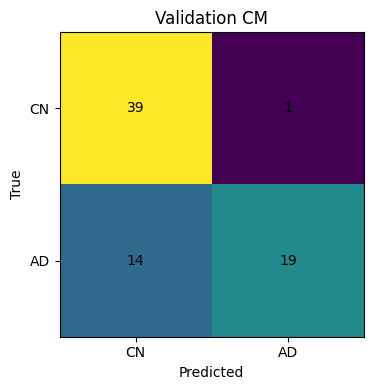


=== TEST ===
Accuracy : 0.7162
Precision: 0.9333
Recall   : 0.4118
F1-score : 0.5714
Confusion matrix:
 [[39  1]
 [20 14]]


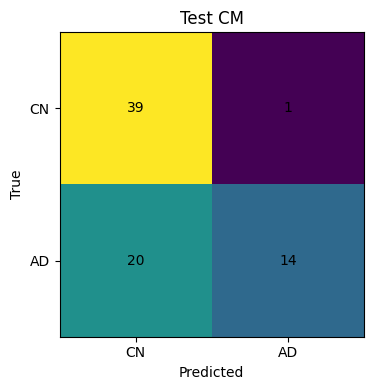

In [36]:
print("\n=== VALIDATION ===")
val_metrics = evaluate_metrics(model, val_loader, device, threshold=threshold_alpha)
print(f"Accuracy : {val_metrics['accuracy']:.4f}")
print(f"Precision: {val_metrics['precision']:.4f}")
print(f"Recall   : {val_metrics['recall']:.4f}")
print(f"F1-score : {val_metrics['f1']:.4f}")
print("Confusion matrix:\n", val_metrics["confusion_matrix"])
plot_confusion_matrix(val_metrics["confusion_matrix"], class_names=("CN","AD"), title="Validation CM")

print("\n=== TEST ===")
test_metrics = evaluate_metrics(model, test_loader, device, threshold=threshold_alpha)
print(f"Accuracy : {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall   : {test_metrics['recall']:.4f}")
print(f"F1-score : {test_metrics['f1']:.4f}")
print("Confusion matrix:\n", test_metrics["confusion_matrix"])
plot_confusion_matrix(test_metrics["confusion_matrix"], class_names=("CN","AD"), title="Test CM")

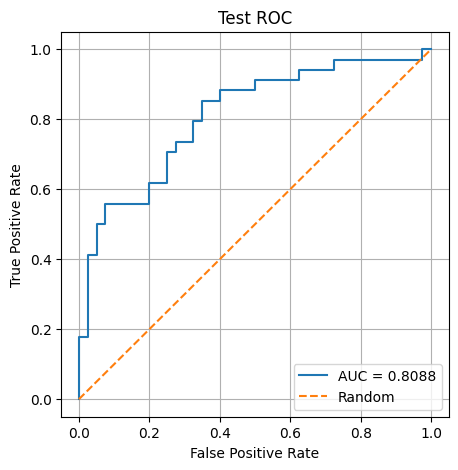

Test AUC: 0.8088


In [48]:
test_auc = plot_roc_curve(
    test_metrics["targets"],
    test_metrics["probs"],
    title="Test ROC"
)

print("Test AUC:", round(test_auc, 4))

# Dự đoán bệnh và giải thích

In [37]:
def predict_and_explain_one_patient(model, nii_path, device, top_k=5, show_raw=False):
    # ===== Load raw volume (optional để show_raw) =====
    if show_raw:
        vol = load_volume(nii_path)
        vol = normalize_volume_2(vol)

    # Preprocess → 48 processed slices
    data_48, slice_index = process_one_nii(nii_path)   # data_48: (48,256,256)

    x = torch.tensor(data_48, dtype=torch.float32)
    x = x.unsqueeze(1).unsqueeze(0).to(device)   # (1,48,1,256,256)

    # Forward 
    model.eval()
    with torch.no_grad():
        logits, alpha = model(x)   # alpha: (1,48)

    probs = torch.softmax(logits, dim=1)
    prob_ad = float(probs[0, 1].item())
    pred = int(prob_ad > threshold_alpha)
    pred_label = "AD" if pred == 1 else "CN"

    print("\n==== MODEL PREDICTION ====")
    print("File:", os.path.basename(nii_path))
    print("Prediction :", pred_label)
    print("P(AD)      :", round(prob_ad, 4))

    # Attention explanation
    w = alpha[0].detach().cpu().numpy()  # (48,)
    top_idx = np.argsort(w)[::-1][:top_k]

    print(f"\n==== TOP {top_k} SLICES (ATTENTION) ====")

    for rank, idx in enumerate(top_idx, 1):
        view, slice_idx = slice_index[idx]

        print(f"Top {rank}: view={view}, slice={int(slice_idx)}, attn={w[idx]:.4f}")

        # show processed slice (đúng input model)
        proc_slice = data_48[idx]  # (256,256)
        show_slice(proc_slice, title=f"PROCESSED | {view} | idx={int(slice_idx)} | attn={w[idx]:.4f}")

        # (optional) show raw slice để debug hướng
        if show_raw:
            raw_slice = extract_slice(vol, view, int(slice_idx))
            show_slice(raw_slice, title=f"RAW | {view} | idx={int(slice_idx)} | attn={w[idx]:.4f}")

    return {
        "pred_label": pred_label,
        "prob_ad": prob_ad,
        "top_idx": [int(i) for i in top_idx],
        "top_alpha": [float(w[i]) for i in top_idx],
    }


In [38]:
def extract_slice(vol, view, idx):
    """
    vol: numpy array (X,Y,Z)
    view: 'axial' | 'coronal' | 'sagittal'
    idx: slice index theo đúng axis của view
    """
    if view == "axial":
        return vol[:, :, idx]      # z = idx
    elif view == "coronal":
        return vol[:, idx, :]      # y = idx
    elif view == "sagittal":
        return vol[idx, :, :]      # x = idx
    else:
        raise ValueError("view phải là 'axial' | 'coronal' | 'sagittal'")

def show_slice(slice2d, title="", transpose=True):
    plt.figure(figsize=(4, 4))
    img = slice2d.T if transpose else slice2d
    plt.imshow(img, cmap="gray", origin="lower")
    plt.title(title)
    plt.axis("off")
    plt.show()

In [39]:
def find_nii_by_patient_id(X_test, y_test, patient_id):
    for p, y in zip(X_test, y_test):
        pid = get_patient_id_from_path(p)
        if pid == patient_id:
            return p, y
    return None, None
    
def query_patient_in_test(
    model,
    X_test,
    y_test,
    patient_id,
    device,
    top_k=5
):
    nii_path, gt = find_nii_by_patient_id(X_test, y_test, patient_id)

    if nii_path is None:
        print("Không tìm thấy patient_id trong TEST:", patient_id)
        return None

    print("==== PATIENT QUERY ====")
    print("patient_id:", patient_id)
    print("nii_path  :", os.path.basename(nii_path))
    print("GT        :", "AD" if gt == 1 else "CN")

    result = predict_and_explain_one_patient(
        model=model,
        nii_path=nii_path,
        device=device,
        top_k=top_k
    )

    return result


==== PATIENT QUERY ====
patient_id: 031_S_0618
nii_path  : ADNI_031_S_0618_MR_MPR-R__GradWarp__N3_Br_20070812130535968_S15271_I67109.nii
GT        : CN

==== MODEL PREDICTION ====
File: ADNI_031_S_0618_MR_MPR-R__GradWarp__N3_Br_20070812130535968_S15271_I67109.nii
Prediction : CN
P(AD)      : 0.351

==== TOP 5 SLICES (ATTENTION) ====
Top 1: view=axial, slice=63, attn=0.0332


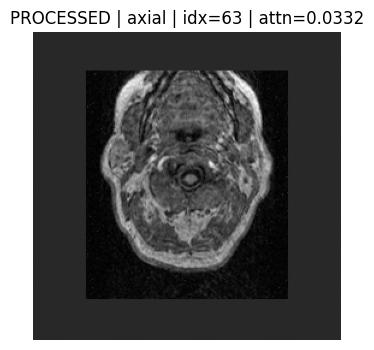

Top 2: view=coronal, slice=78, attn=0.0317


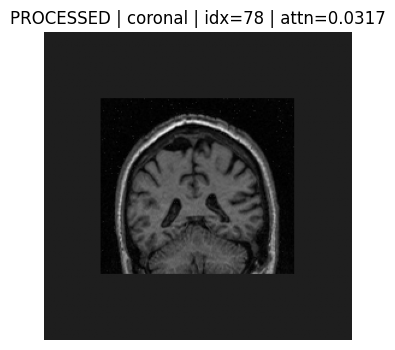

Top 3: view=axial, slice=89, attn=0.0310


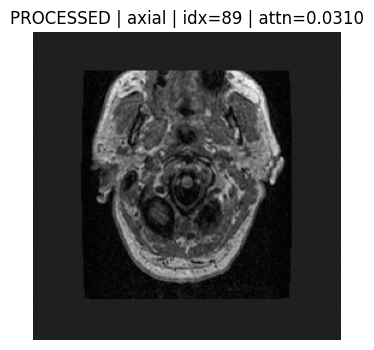

Top 4: view=axial, slice=141, attn=0.0275


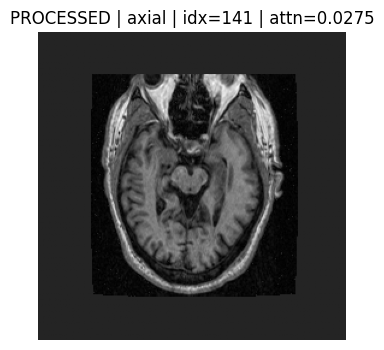

Top 5: view=sagittal, slice=56, attn=0.0268


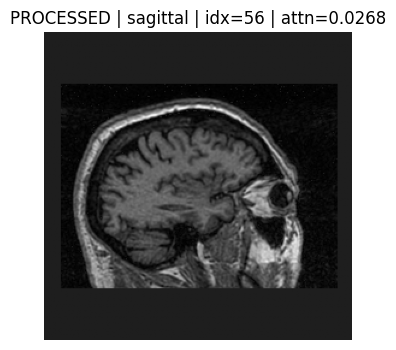

{'pred_label': 'CN',
 'prob_ad': 0.35103750228881836,
 'top_idx': [1, 20, 2, 12, 37],
 'top_alpha': [0.03317811340093613,
  0.03166356682777405,
  0.03097541257739067,
  0.027454253286123276,
  0.0267792958766222]}

In [43]:
patientId = "031_S_0618"
query_patient_in_test(
    model=model,
    X_test=X_test,
    y_test=y_test,
    patient_id=patientId,
    device=device,
    top_k=numer_of_top_slices
)